# Environmental analysis: weather influence on phosphorus in swiss lakes

## Introduction
This report present the results qnd interpretation of the analysis of environmental data about phosphorus concentration in lakes in Switzerland, as well as weather data (insolation, rainfall, temperature, fresh snow) in several locations in the country. This work aim to identify tendancies and changes over time. But the main objective is to show if there is any potential correlations between the concentration of phosphorus and climate in swiss lakes.

## Material and methods
### Datasets
This work is based on two datasets available on [opendata.swiss](https://opendata.swiss):
- [Klimadaten: Sonnenscheindauer, Niederschlag, Temperatur und Neuschnee](https://opendata.swiss/en/dataset/klimadaten-sonnenscheindauer-niederschlag-temperatur-und-neuschnee4) (Climate data: insolation time, precipitation, temperature and fresh snowfall)
- [Phosphorgehalt in Seen](https://opendata.swiss/en/dataset/phosphorgehalt-in-seen5) (Phosphorus content in lakes).
The climate dataset consist in four sheets (insolation time in h per year, precipitation in cumulative mm per year, temperature in mean °C per year, and fresh snowfall in cumulative cm per year) of data for 13 locations (Basel-Binningen, Bern- Zollikofen, Davos, Geneva-Cointrin, Locarno-Monti, Lugano, Lucerne, Neuchâtel, Säntis, Sion, St-Gallen and Zurich-Fluntern) from 1931 to 2024. The phosphorus dataset consist in a table of the annual measurements of phosphorus concentration in µg/l in six lakes (lake Lucerne, lake Hallwil, lake Neuchâtel, lake Constance, lake Zug and lake Geneva) from 1951 (first data from 1957) to 2023.

### Methods
#### Cleaning and importing the data
First, the datasets have been cleaned in LibreOffice Calc. Next to making the files more easily usable with Python, the cleaning was also usefull to get rid of all irrelevant data. This particularly concerns the locations in the climate dataset.

The phosphorus dataset covers six lakes, whereas the climate dataset covers 13 locations, most of which being quite remote from the said lakes. So, in order to get the most accurate climate data for the lakes, only the locations closest to the lakes were retained in the climate dataset. For Lake Lucerne, Lake Neuchâtel and Lake Geneva, the locations retained were quite obviously Lucerne, Neuchâtel and Geneva-Cointrin, since they are next to the lakes. For the Lake Constance and Lake Zug, St-Gallen and Lucerne respectively were retained since they are the closest location in proximity and altitude. Concerning Lake Hallwil, both Lucerne and Zurich-Fluntern are the best candidates in terms of proximity and altitude. However, Lucerne was chosen since the city is a bit smaller than Zurich, slighlty reducing the influence of urbanism. In addition, there are several peaks between the lake and Zurich, whereas the space between the lake and Lucerne is a bit flatter, potentially resulting in a bigger climatic difference between the lake and Zurich than between the lake and Lucerne. Zurich-Fluntern was nevertheless kept in the dataset, for comparison purposes.

After the cleaning, the spreadsheet files were imported using the pandas package.

In [7]:
# Importing required package
import pandas as pd

# Importing the datasets
phosphorus = pd.read_excel("phosphorus-lakes.xlsx", na_values=["..."])
insolation = pd.read_excel("weather-data.xlsx", sheet_name="Insolation", na_values=["..."])
rainfall = pd.read_excel("weather-data.xlsx", sheet_name="Rainfall", na_values=["..."])
temperature = pd.read_excel("weather-data.xlsx", sheet_name="Temperature", na_values=["..."])
snow = pd.read_excel("weather-data.xlsx", sheet_name="Fresh snow", na_values=["..."])

#### Exploratory analysis
Before looking for possible correlations, some basic analyses were performed. First, the descriptive statistics of each dataset were calculated. Then, these datasets were analyzed to identify linear trends, and the data were plotted in scatter plots, so that the trends could be visualized. Finally, the descriptive statistics, trend analysis results, and trend comparisons between the variables were stored in a JSON file, for easier access.

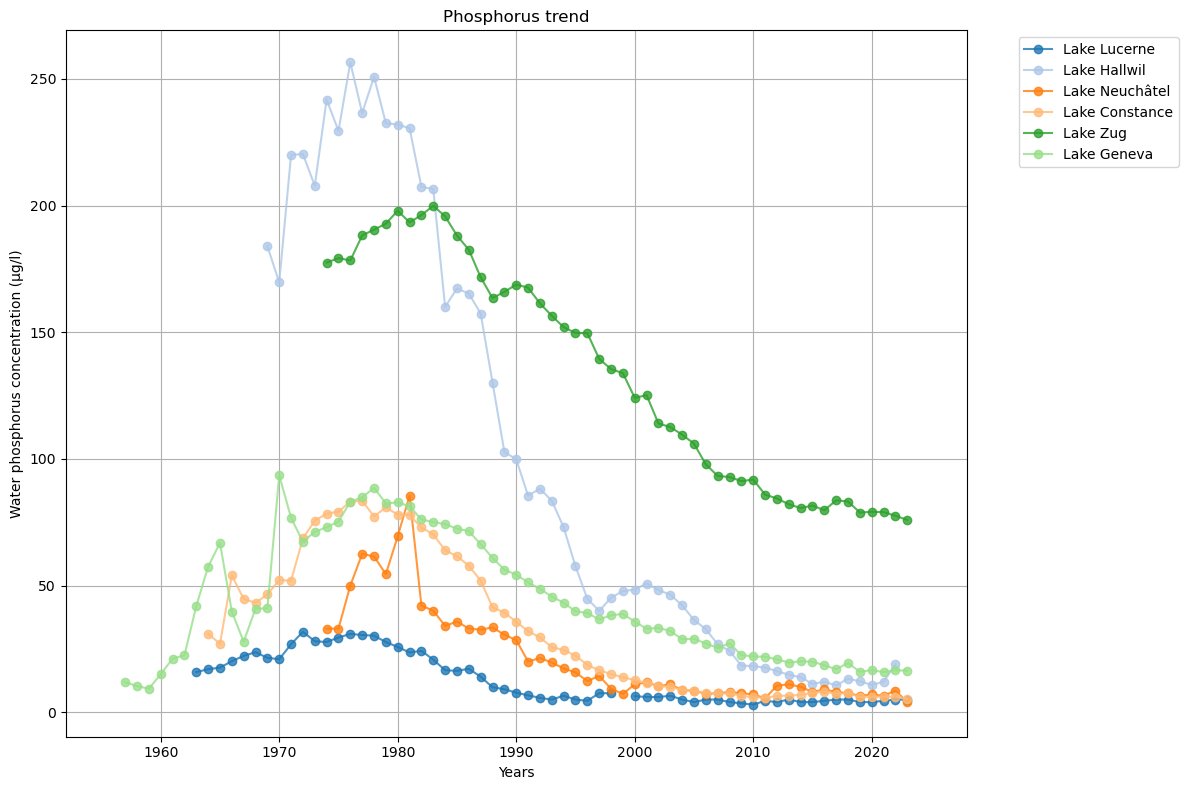

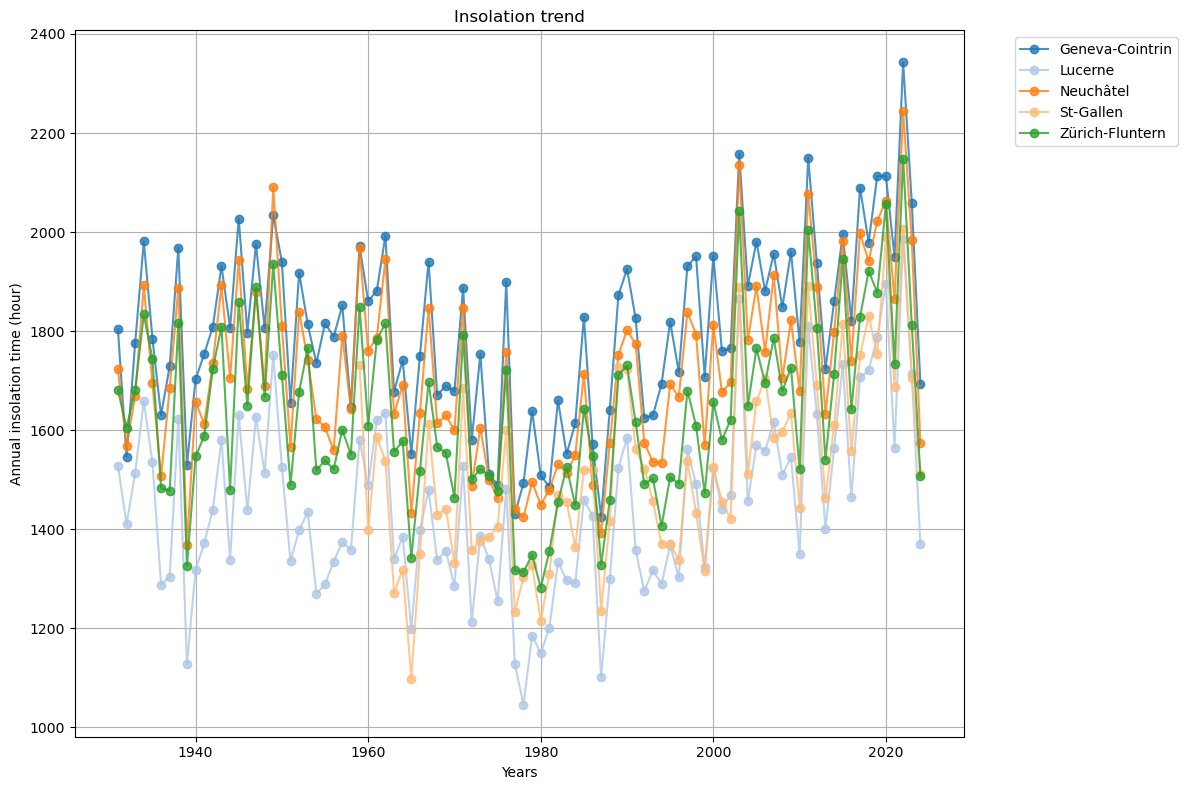

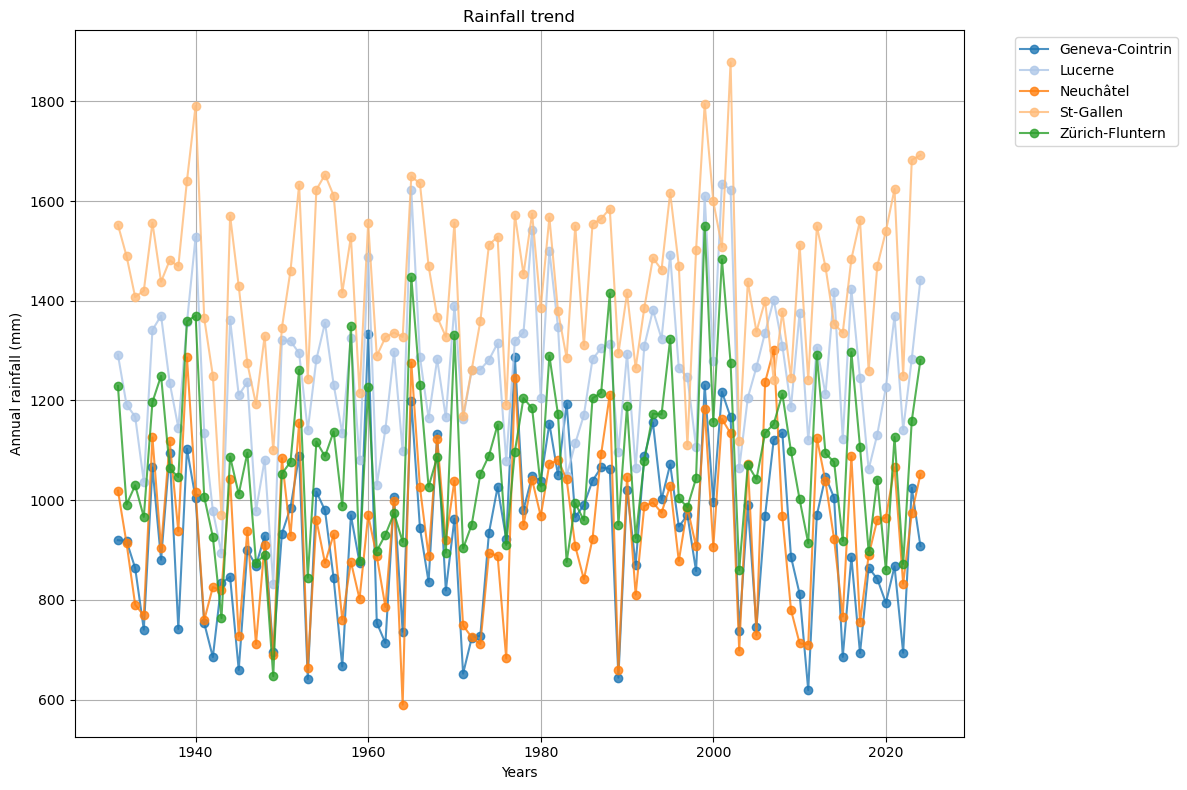

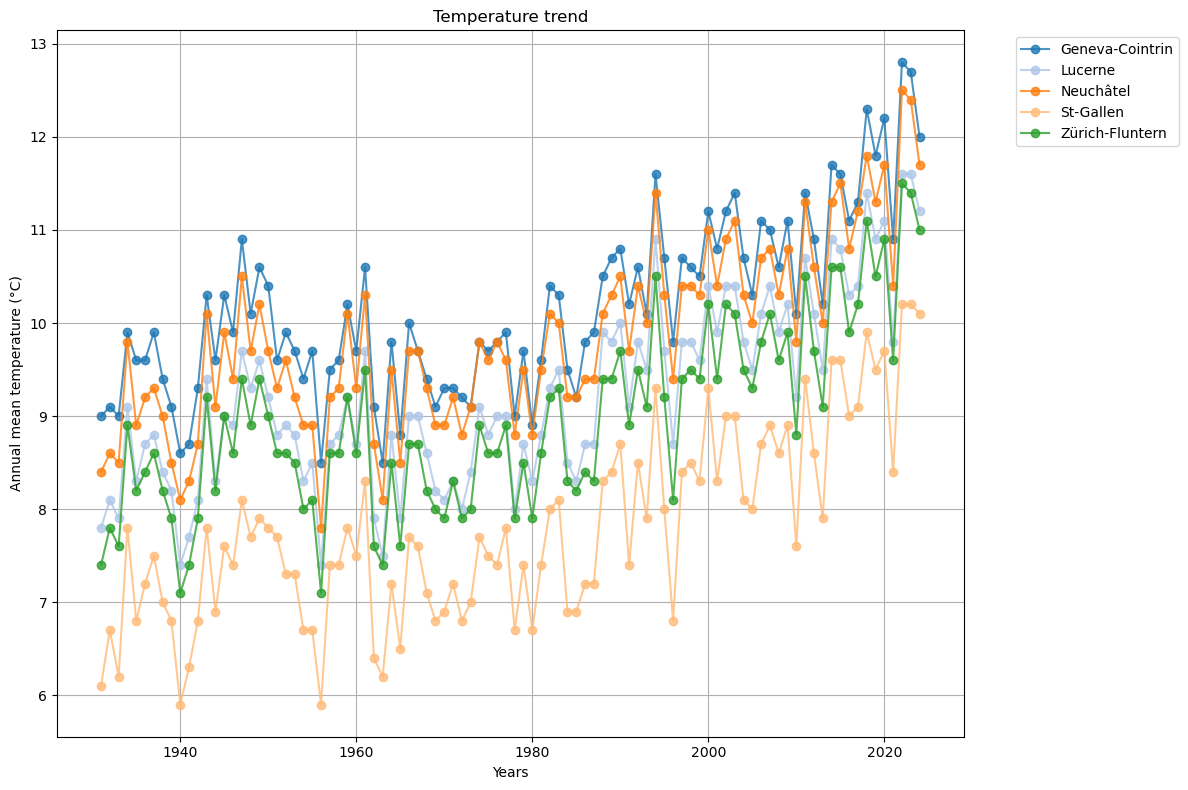

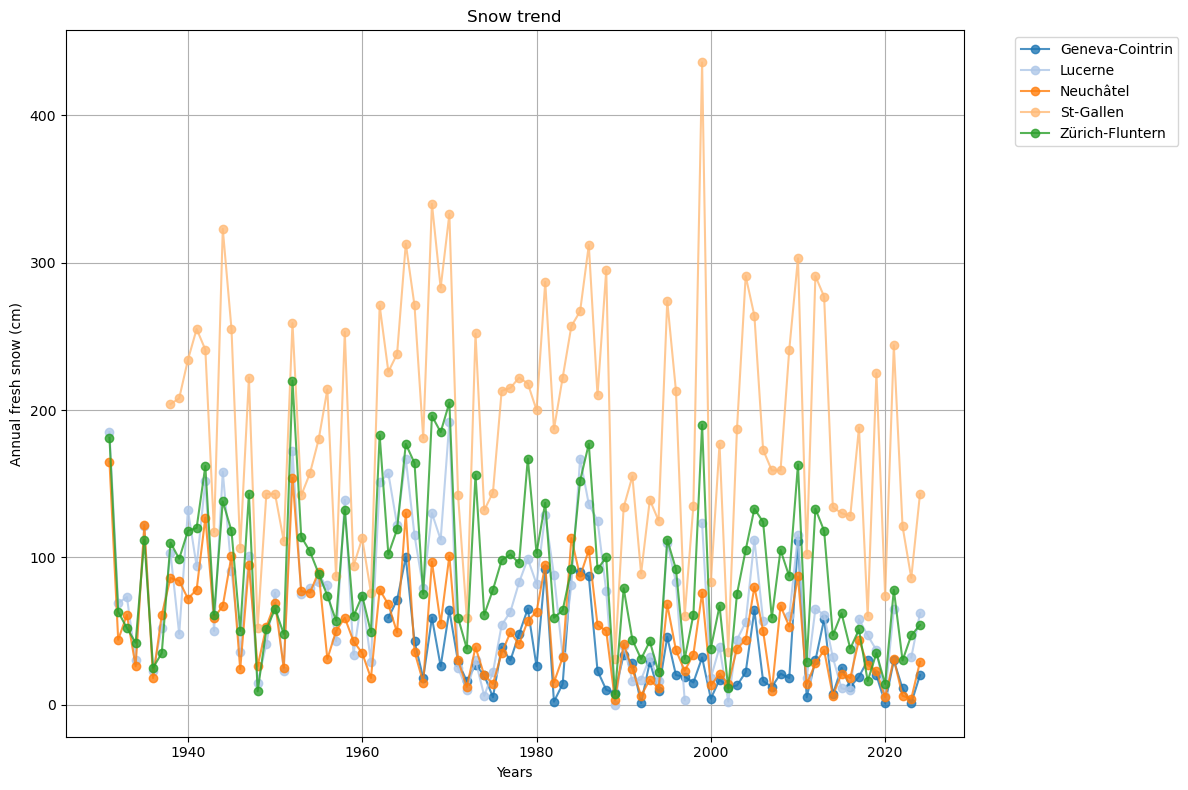

Trends analysis completed. The results are saved in 'trends_results.json'.


In [8]:
# Importing required packages
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt
import json

# Function to generate descriptive statistics
def desc_stat(df, x_col, y_col):
    stats = df[[x_col, y_col]].iloc[:, 1:].describe().to_dict()
    return stats

# Function for analysing linear trends
def detect_trends(df, x_col, y_col):
    # Removing NaN values for both columns
    valid_data = df[[x_col, y_col]].dropna()
    
    # Making sure there is enough values for the analysis
    if len(valid_data) > 1:
        x = valid_data[x_col].astype(float)
        y = valid_data[y_col].astype(float)
        regression = linregress(x, y)
        trend = "positive" if regression.slope > 0 else "negative"
        return {"slope": regression.slope, "intercept": regression.intercept, "r_value": regression.rvalue, "trend": trend}
    else:
        return None

# Function for plotting graphs
def plot_graph(dataframes, x_col, y_cols, title, xlab, xlim_inf, xlim_sup, ylab):
    plt.figure(figsize=(12, 8))

    cmap = plt.get_cmap("tab20") # Use color map with 20 different colors
    num_colors = cmap.N # Get the number of colors in the color map

    for i, (df, y_col, label) in enumerate(dataframes):
        color = cmap(i % num_colors) # Cycle through the color map
        plt.plot(df[x_col], df[y_col], marker = "o", linestyle = "-", label = label, color = color, alpha = 0.8)
    
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.grid(True)
    plt.xlim(xlim_inf,xlim_sup)
    plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left") # Avoid overlapping with the graph
    plt.tight_layout()
    plt.show()

# Function for comparing trends
def compare_trends(trend1, trend2):
    if trend1["trend"] == trend2["trend"]:
        return "Trends are similar."
    else:
        return "Trends are opposite."

# Trends detection for each dataset
trends_results = {}
descriptive_stats = {}
comparisons = {}

# Phosphorus analysis
lakes = phosphorus.columns[1:]
data_to_plot = []
trends_results["Phosphorus"] = {}
descriptive_stats["Phosphorus"] = {}
for lake in lakes:
    trend = detect_trends(phosphorus, "Year", lake)
    stats = desc_stat(phosphorus, "Year", lake)
    if trend:
        trends_results["Phosphorus"][lake] = trend
        descriptive_stats["Phosphorus"][lake] = stats
        data_to_plot.append((phosphorus, lake, lake))
plot_graph(data_to_plot, "Year", lakes, "Phosphorus trend", "Years", 1952, 2028, "Water phosphorus concentration (µg/l)")

# Weather analysis
for dataset_name, dataset, y_legend in [("Insolation", insolation, "Annual insolation time (hour)"), ("Rainfall", rainfall, "Annual rainfall (mm)"), ("Temperature", temperature, "Annual mean temperature (°C)"), ("Snow", snow, "Annual fresh snow (cm)")]:
    stations = dataset.columns[1:]
    data_to_plot = []
    trends_results[dataset_name] = {}
    descriptive_stats[dataset_name] = {}

    for station in stations:
        trend = detect_trends(dataset, "Year", station)
        stats = desc_stat(dataset, "Year", station)

        if trend:
            trends_results[dataset_name][station] = trend
            descriptive_stats[dataset_name][station] = stats
            data_to_plot.append((dataset, station, station))

    plot_graph(data_to_plot, "Year", stations, f"{dataset_name} trend", "Years", 1926, 2029, y_legend)

# Comparing trends
for lake, phos_trend in trends_results["Phosphorus"].items():
    for climate_type in ["Insolation", "Rainfall", "Temperature", "Snow"]:
        for station, climate_trend in trends_results[climate_type].items():
            comparison = compare_trends(phos_trend, climate_trend)
            comparisons[f"{lake} vs {station} ({climate_type})"] = comparison

for climate_type1 in ["Insolation", "Rainfall", "Temperature", "Snow"]:
    for station1, trend1 in trends_results[climate_type1].items():
        for climate_type2 in ["Insolation", "Rainfall", "Temperature", "Snow"]:
            if climate_type1 != climate_type2:
                for station2, trend2 in trends_results[climate_type2].items():
                    comparison = compare_trends(trend1, trend2)
                    comparisons[f"{station1} ({climate_type1}) vs {station2} ({climate_type2})"] = comparison

# Saving trends results
with open("trends_results.json", "w") as f:
    json.dump({"Descriptive statistics": descriptive_stats, "Trends analysis results": trends_results, "Trends comparison": comparisons}, f, indent=4)

print("Trends analysis completed. The results are saved in 'trends_results.json'.")

#### Correlations and regression models
First, correlations between the phosphorus concentration and the climate data (insolation time, annual rainfall, mean annual temperature, annual fresh snow) were calculated. Then, regression models were applied.

The first model is a multilple linear regression model, as a starting point. Then, because of multicolinearity between climate data, the Ridge correlation model was tested. At the same time, a Lasso regression model was also tested, in case of non-explanatory variables. Finally, the Random Forest Regressor model was also tested, in case of non-linear relation between the variables.

In [ ]:
# Importing required packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Dictionnary for correspondance between lakes (phosphorus) and stations (weather)
lake_to_station = {
        "Lake Lucerne": "Lucerne",
        "Lake Hallwil": "Lucerne",
        "Lake Neuchâtel": "Neuchâtel",
        "Lake Constance": "St-Gallen",
        "Lake Zug": "Lucerne",
        "Lake Geneva": "Geneva-Cointrin"
        }

# Melting the dataframes
phosphorus_melted = phosphorus.melt(id_vars="Year", var_name="Lake", value_name="Phosphorus")
insolation_melted = insolation.melt(id_vars="Year", var_name="Station", value_name="Insolation")
rainfall_melted = rainfall.melt(id_vars="Year", var_name="Station", value_name="Rainfall")
temperature_melted = temperature.melt(id_vars="Year", var_name="Station", value_name="Temperature")
snow_melted = snow.melt(id_vars="Year", var_name="Station", value_name="Snow")

# Mapping lakes to stations
phosphorus_melted["Station"] = phosphorus_melted["Lake"].map(lake_to_station)

# Merging dataframes together
merged_inso = pd.merge(phosphorus_melted, insolation_melted, on=["Year", "Station"], how="left")
merged_rain = pd.merge(phosphorus_melted, rainfall_melted, on=["Year", "Station"], how="left")
merged_temp = pd.merge(phosphorus_melted, temperature_melted, on=["Year", "Station"], how="left")
merged_snow = pd.merge(phosphorus_melted, snow_melted, on=["Year", "Station"], how="left")

weather_full = insolation_melted \
        .merge(rainfall_melted, on=["Year", "Station"], how="outer") \
        .merge(temperature_melted, on=["Year", "Station"], how="outer") \
        .merge(snow_melted, on=["Year", "Station"], how="outer")

phospho_weather = pd.merge(phosphorus_melted, weather_full, on=["Year", "Station"], how="left")

# Correlation beetwen phosphorus and climate data per lake
for lake in phospho_weather["Lake"].unique():
    subset = phospho_weather[phospho_weather["Lake"] == lake]
    print(f"\nCorrelation for {lake.title()}:")
    print(subset[["Phosphorus", "Insolation", "Rainfall", "Temperature", "Snow"]].corr()["Phosphorus"])

# Linear regression scatter plot
for var in ["Insolation", "Rainfall", "Temperature", "Snow"]:
    sns.lmplot(data=phospho_weather, x=var, y="Phosphorus", col="Lake", col_wrap=3, height=4, aspect=4)
    plt.subplots_adjust(top=0.9)
    plt.suptitle(f"Phosphorus vs {var} per lake")
    plt.show()

# Multiple linear regression

results_list = []

for lake in phospho_weather["Lake"].unique():
    subset = phospho_weather[phospho_weather["Lake"] == lake].dropna()
    x = subset[["Insolation", "Rainfall", "Temperature", "Snow"]]
    y = subset["Phosphorus"]
    x = sm.add_constant(x) # Add constant for intercept
    model = sm.OLS(y, x).fit()
    summary = model.summary2().tables[1] # Get coefficient and P-values
    significant = summary[summary["P>|t|"] < 0.05].index.tolist()
    if "const" in significant:
        significant.remove("const")
    print(f"\n{lake.title()} - Linear regression:")
    print(model.summary())
    residuals = model.resid
    fitted = model.fittedvalues

    results_list.append({
        "lake": lake,
        "R²": round(model.rsquared, 3),
        "Adj. R²": round(model.rsquared_adj, 3),
        "Significant predictors": ",".join(significant) if significant else "None",
        "Cond. no": int(np.linalg.cond(x)), # Rough multicollinearity indicator
        "multicollinearity": "Yes" if np.linalg.cond(x) > 3000 else "No"
        })

    # Residuals distribution
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True, color="skyblue")
    plt.title(f"Residuals distribution - {lake}")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Residuals vs fitted values
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=fitted, y=residuals)
    plt.axhline(0, linestyle="--", color="red")
    plt.title(f"Residuals vs fitted values - {lake}")
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

summary_df = pd.DataFrame(results_list)
print(summary_df)

# Heatmap of the correlations
for lake in phospho_weather["Lake"].unique():
    subset = phospho_weather[phospho_weather["Lake"] == lake]
    corr = subset[["Phosphorus", "Insolation", "Rainfall", "Temperature", "Snow"]].corr()

    # Deleting phosphorus to avoid correlating to itself
    corr_trimmed = corr.drop("Phosphorus").drop("Phosphorus", axis=1)

    plt.figure(figsize=(6, 5))
    sns.heatmap(corr_trimmed, annot=True, cmap="coolwarm", center=0, linewidths=0.5, vmin=-1, vmax=1)
    plt.title(f"Correlation between climate data - {lake}")
    plt.tight_layout()
    plt.show()

# Testing Ridge and Lasso regression models to see if it fits better to the data
models = {
        "Ridge": Ridge(alpha=1.0),
        "Lasso": Lasso(alpha=0.1, max_iter=10000)
        }

ridge_lasso_results = []

for lake in phospho_weather["Lake"].unique():
    subset = phospho_weather[phospho_weather["Lake"] == lake].dropna()
    x = subset[["Insolation", "Rainfall", "Temperature", "Snow"]]
    y = subset["Phosphorus"]

    # Standardisation
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)

    # Split
    x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

    for model_name, model in models.items():
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        ridge_lasso_results.append({
            "Lake": lake,
            "Model": model_name,
            "R² test": round(r2_score(y_test, y_pred), 3),
            "RMSE test": round(root_mean_squared_error(y_test, y_pred), 3),
            "Coefficients": dict(zip(x.columns, [round(c, 3) for c in model.coef_]))
            })

# Printing test results, and coefficients in a separate table (coefficients too long for first print)
ridge_lasso_df = pd.DataFrame(ridge_lasso_results)
for index, row in ridge_lasso_df.iterrows():
    print(f"Lake: {row['Lake']}, Model: {row['Model']}, R²: {row['R² test']}, RMSE: {row['RMSE test']}")
coeffs_df = pd.DataFrame([row["Coefficients"] for index, row in ridge_lasso_df.iterrows()])
coeffs_df.index = ridge_lasso_df["Lake"] + "-" + ridge_lasso_df["Model"]
print(coeffs_df)

# Testing random Forest regression
rf_results = []
for lake in phospho_weather["Lake"].unique():
    subset = phospho_weather[phospho_weather["Lake"] == lake].dropna()
    x = subset[["Insolation", "Rainfall", "Temperature", "Snow"]]
    y = subset["Phosphorus"]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)

    rf_results.append({
        "Lake": lake,
        "Model": "Random Forest",
        "R² test": round(r2_score(y_test, y_pred), 3),
        "RMSE test": round(root_mean_squared_error(y_test, y_pred), 3)
        })

rf_df = pd.DataFrame(rf_results)
print(rf_df)

## Results
### Exploratory analysis
Concerning the trend analysis of the phosphorus, all trends are globally negative. However, when looking at the plots, we can see that, for all lakes, the curve start with increasing values until the 70s and early 80s. From then on, the tendency is inverted, with decreasing values.

Concerning the trend analysis of the weather data, it is much more diverse. This is particularly true for the insolation time and rainfall. On the other hand, concerning the temperature and the fresh snow, the trends are all the same for every location: positive trend for the temperature (increasing values over time), and negative trend for the fresh snow (decreasing values over time).

### Correlations and regression models
